In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import scipy.signal as signal
plt.rcParams.update({'font.size': 15})

from LMS_ecg import LMS

*The second exam deals with adaptive filters. Your job is to investigate an adaptive filtering problem and write a small report in the style of a laboratory journal. You will need to include a theoretical background, explain your choice and settings of the adaptive algorithm(s), perform numerical experiments and finally present, analyze and discuss the results. You can use one of the five exercises from the class as the starting point, but you are also free to pick your own problem to work from.*

# Filtering of noisy ECG signals
In this exercise we will use the LMS algorithm for suppressing interference from a signal of interest.
The signal is a measurement of a electrical activity of the heart of a human. This is also known as
an electrocardiogram (ECG). In our case the measurement is contaminated by sinusoidal interference
from the power network

![EKG_problem](img/EKG_problem.png)



## Load noisy data file and find noise frequency

In [2]:
def load_data(path):
    with open(path) as data:
        out = data.readlines()

    return [float(x) for x in out]

In [3]:
path = './ecg.txt'
sample_rate = 500  # Hz
ecg_data = np.array(load_data(path))
ecg_data /= np.max(ecg_data)

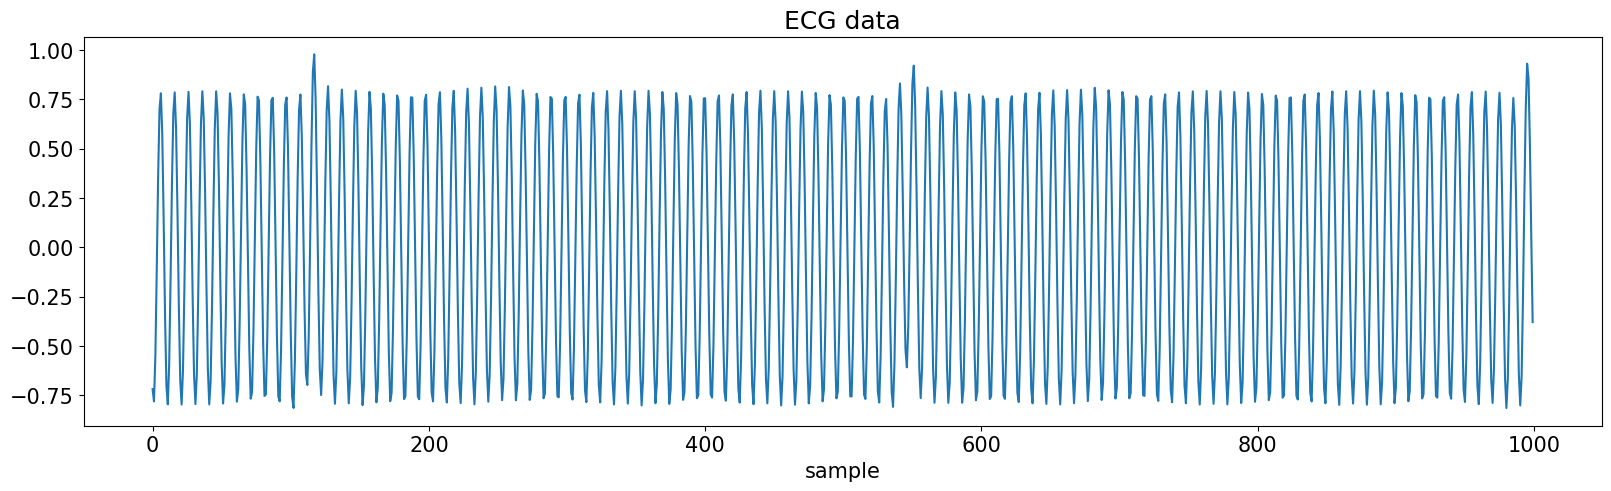

In [4]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('sample')

ax.set_title('ECG data')
ax.plot(ecg_data[:1000])
plt.show()

To remove the power line noise, I use an LMS based algorithm, trying to cancel the noise with a power line frequency signal. To find this noise frequency we estimate the PSD using Bartlett and Welch's method.

In [5]:
_, ecg_spectrum = signal.welch(ecg_data, fs=sample_rate,nperseg=512)
norm_frequencies = np.linspace(0,1,len(ecg_spectrum))  # in units of pi

Assuming a gaussian peak **Later replace with gaussian fit**

In [6]:
peak = np.argmax(ecg_spectrum)

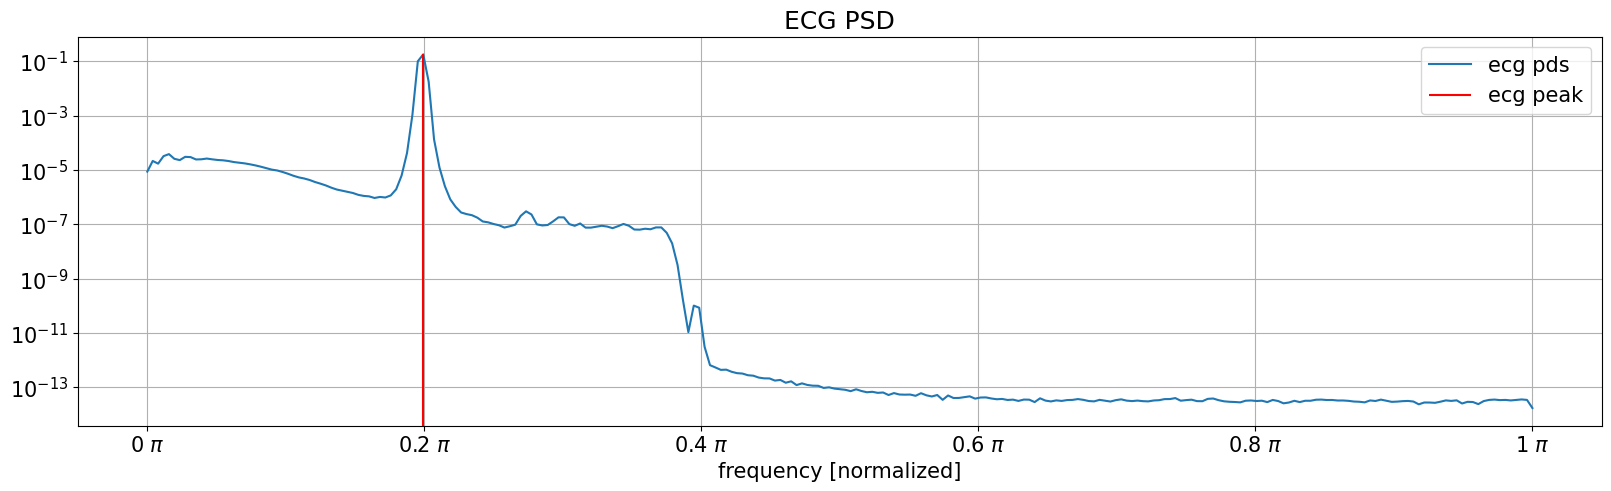

In [7]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG PSD')
ax.semilogy(norm_frequencies, ecg_spectrum, label='ecg pds')
ax.vlines(norm_frequencies[peak], ymin=0, ymax=ecg_spectrum[peak], colors='r', label='ecg peak')
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()

In [8]:
noise_frequency = norm_frequencies[peak]

## Setup adaptive filter

In [9]:
# simulated noise
noise = np.cos(np.pi*np.arange(len(ecg_data))* noise_frequency)  # frequency is in units of pi

Plot as sanity check

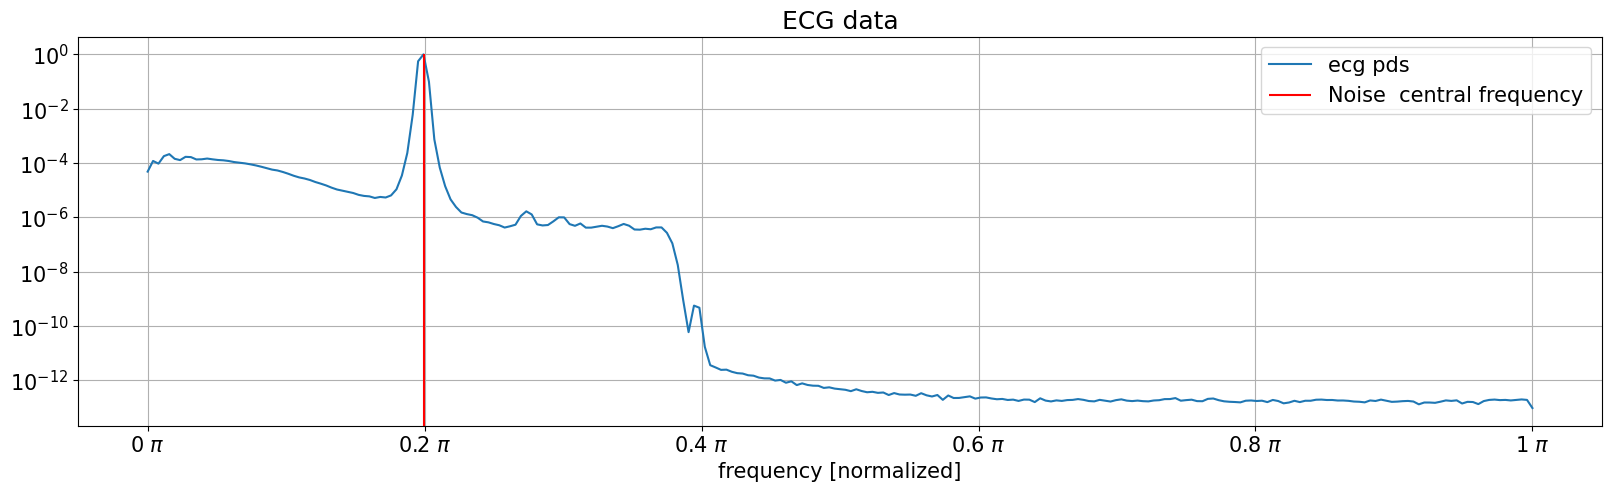

In [86]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG data')
ax.semilogy(norm_frequencies, ecg_spectrum/np.max(ecg_spectrum), label='ecg pds')
ax.vlines(noise_frequency, ymin=0, ymax=1, colors='r', label='Noise  central frequency')
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()


Noise frequency seems ok

## Implement LMS

In [79]:
taps = 5
weights = np.zeros(taps)
step_size = 0.005
lms = LMS(signal=noise, desired_signal=ecg_data, weights=weights, step_size=step_size)

In [80]:
lms.adapt_weights()
weights = lms.weights[:,-1]

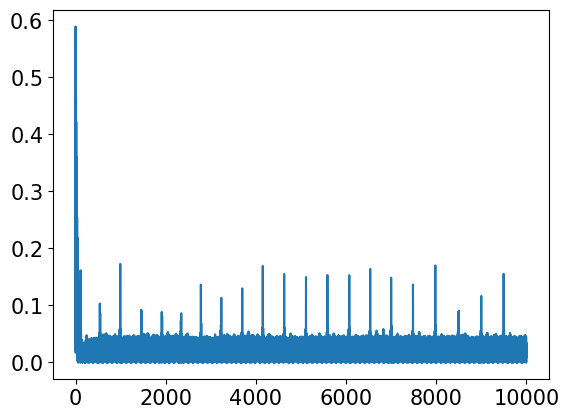

In [81]:
plt.plot(lms.error[:10000]**2)


In [68]:
freq, filt_rsp = signal.freqz(weights)

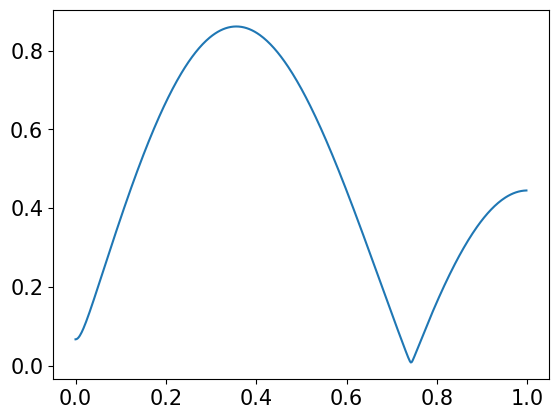

In [88]:
plt.plot(freq/np.pi, np.abs(filt_rsp))

plt.show()

In [62]:
filtered_ecg = signal.lfilter(weights, [1], ecg_data)

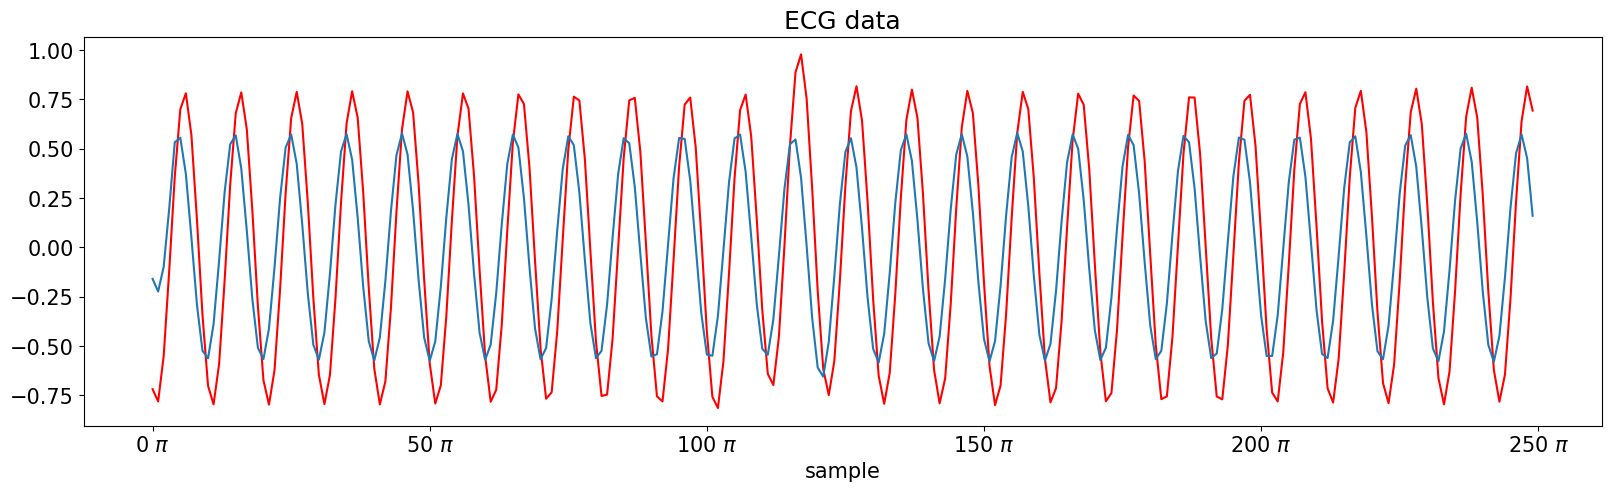

In [89]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('sample')

ax.set_title('ECG data')
ax.plot(ecg_data[:250], 'r', label='Polluted ECG data')
ax.plot(filtered_ecg[:250], label='Filtered ECG data')

plt.show()

In [82]:
_, ecg_spectrum_filt = signal.welch(filtered_ecg, fs=sample_rate,nperseg=512)

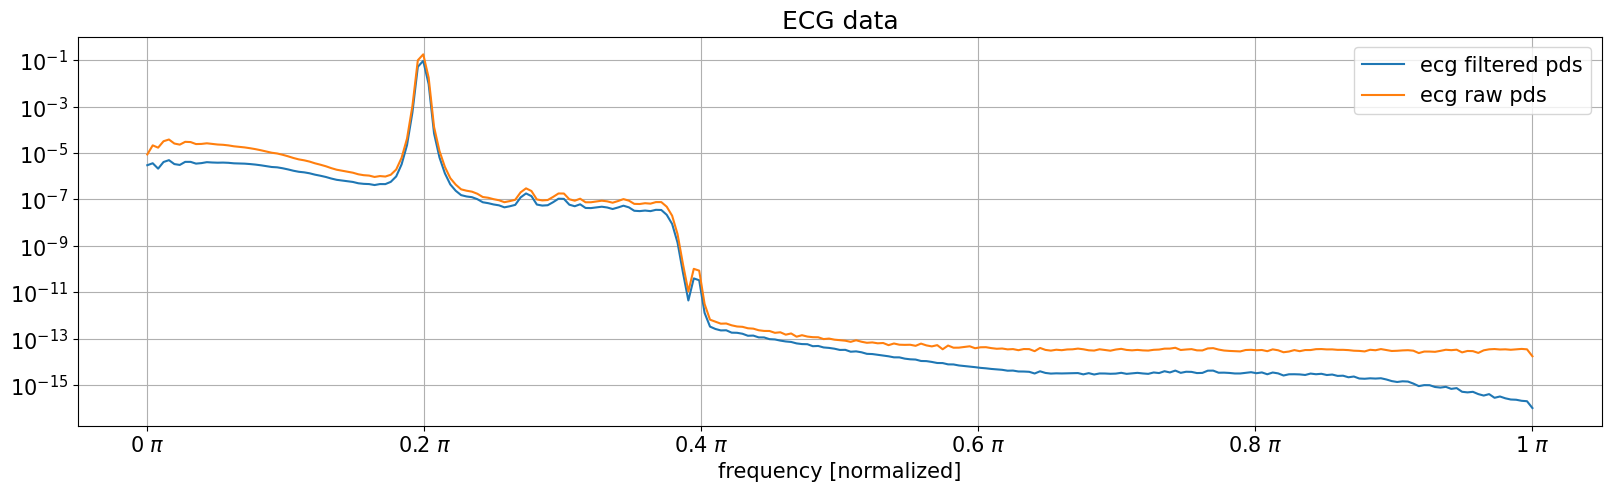

In [90]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG data')
ax.semilogy(norm_frequencies, ecg_spectrum_filt, label='ecg filtered pds')
ax.semilogy(norm_frequencies, ecg_spectrum, label='ecg raw pds')

ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()
